# Fine-tuning Florence-2 on Object Detection Dataset

Florence-2는 MIT 라이선스에 따라 Microsoft에서 오픈 소스로 제공하는 경량 비전 언어 모델입니다. 이 모델은 캡션, 객체 감지, 접지 및 세분화와 같은 작업 전반에 걸쳐 강력한 제로샷 및 미세 조정 기능을 보여줍니다.

모델은 이미지와 작업 프롬프트를 입력으로 받아 원하는 결과를 텍스트 형식으로 생성합니다. DaViT 비전 엔코더를 사용하여 이미지를 시각적 토큰 임베딩으로 변환합니다. 그런 다음 BERT에서 생성된 텍스트 임베딩과 연결되고 트랜스포머 기반 멀티 모달 인코더 디코더에 의해 처리되어 응답을 생성합니다.

In [1]:
!nvidia-smi

Thu Sep 26 10:45:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:3B:00.0 Off |                  Off |
| 35%   37C    P8              14W / 450W |     51MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Download example data 예제 데이터 다운로드

In [2]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 511M
-rw-rw-r--  1 user user 220M  9월 20 11:09 all_embeddings.json
-rw-rw-r--  1 user user 6.9K  9월 23 13:13 auto-label-with-yolo-world.ipynb
drwxrwxr-x  5 user user 4.0K  9월 19 14:44 COCO-128-2
-rw-rw-r--  1 user user  43M  9월 20 11:09 data.bin
-rw-rw-r--  1 user user  12K  9월 19 15:07 dinov2-classification.ipynb
-rw-rw-r--  1 user user 3.7M  9월 20 11:11 dinov2-image-retrieval-eval.ipynb
-rw-rw-r--  1 user user 4.6M  9월 19 16:50 dinov2-image-retrieval.ipynb
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.1
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.2
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.3
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.4
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.5
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.6
-rw-rw-r--  1 user user 104K  6월  3  2023 dog.jpeg.7
-rw-rw-r--  1 user user  95M  9월 19 14:40 eval_embeddings.json
-rw-rw-r--  1 user user 2.4M  9월 26 10:45 fine

In [3]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

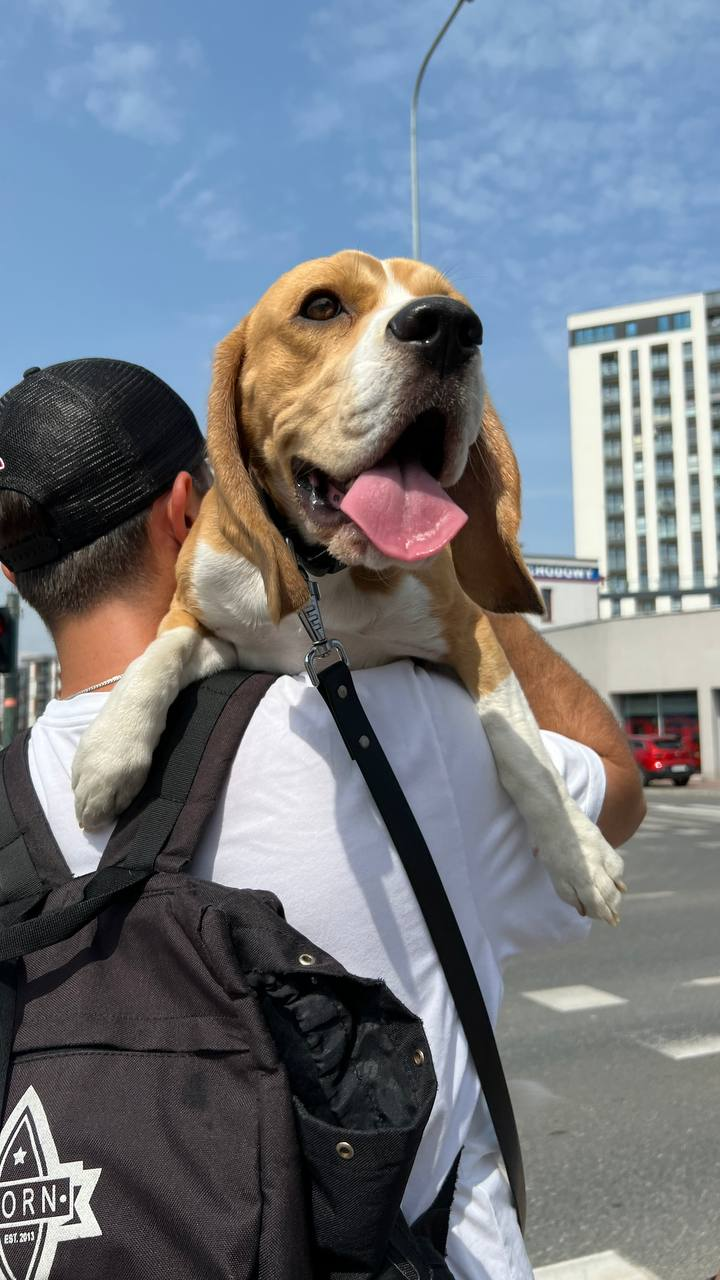

In [4]:
from PIL import Image

image = Image.open(EXAMPLE_IMAGE_PATH)
display(image)

In [5]:
!pip install -q transformers flash_attn timm einops peft

In [6]:
import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

In [7]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, torch_dtype='auto').eval().to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True)

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884


## 사전 훈련된 Florence-2 모델로 추론 실행

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


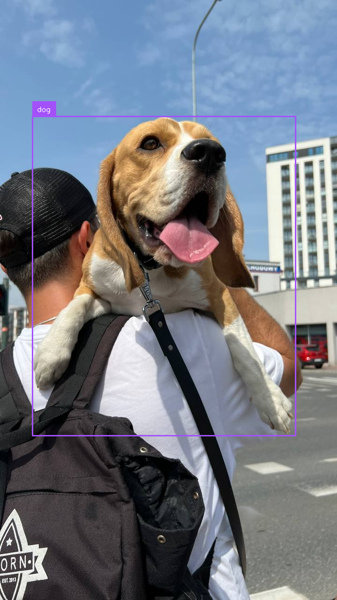

In [8]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = ""

inputs = processor(
    text = text,
    images=image,
    return_tensors="pt").to(DEVICE, model.dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    early_stopping=False,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(
    generated_text,
    task=task,
    image_size=(image.width, image.height)
)
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [9]:
detections

Detections(xyxy=array([[ 69.48   , 248.95999, 631.08   , 929.92   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['dog'], dtype='<U3')})

In [10]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = ""

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE, model.dtype)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'dog<loc_96><loc_194><loc_876><loc_726>'}

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


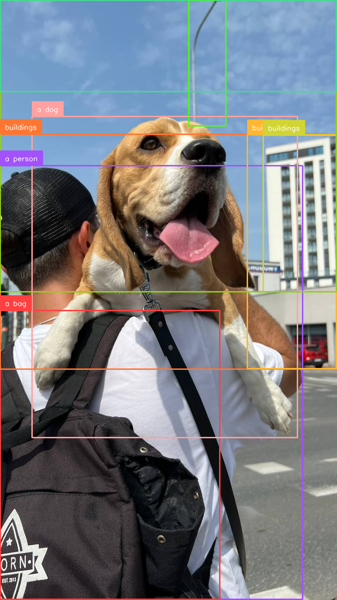

In [11]:
image = Image.open(EXAMPLE_IMAGE_PATH)
task = '<CAPTION_TO_PHRASE_GROUNDING>'
text = "<CAPTION_TO_PHRASE_GROUNDING> In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE, model.dtype)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image
     

## Roboflow Universe에서 데이터셋 다운로드

### Roboflow 100
https://www.rf100.org/visual.html?ref=blog.roboflow.com

In [12]:
# https://universe.roboflow.com/roboflow-jvuqo/poker-cards-fmjio/dataset/4#

from roboflow import Roboflow
rf = Roboflow(api_key="37VIatP5I95TJhzXRlvI")
project = rf.workspace("roboflow-jvuqo").project("poker-cards-fmjio")
version = project.version(4)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...


In [13]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"IMG_20220316_172418_jpg.rf.e3cb4a86dc0247e71e3697aa3e9db923.jpg","prefix":"<OD>","suffix":"9 of clubs<loc_138><loc_100><loc_470><loc_448>10 of clubs<loc_388><loc_145><loc_670><loc_453>jack of clubs<loc_566><loc_166><loc_823><loc_432>queen of clubs<loc_365><loc_465><loc_765><loc_999>king of clubs<loc_601><loc_440><loc_949><loc_873>"}
{"image":"IMG_20220316_171515_jpg.rf.e3b1932bb375b3b3912027647586daa8.jpg","prefix":"<OD>","suffix":"5 of clubs<loc_554><loc_2><loc_763><loc_467>6 of clubs<loc_399><loc_79><loc_555><loc_466>7 of clubs<loc_363><loc_484><loc_552><loc_905>8 of clubs<loc_535><loc_449><loc_757><loc_971>"}
{"image":"IMG_20220316_165139_jpg.rf.e30257ec169a2bfdfecb693211d37250.jpg","prefix":"<OD>","suffix":"9 of diamonds<loc_596><loc_535><loc_859><loc_982>jack of diamonds<loc_211><loc_546><loc_411><loc_880>queen of diamonds<loc_430><loc_34><loc_692><loc_518>king of diamonds<loc_223><loc_96><loc_451><loc_523>10 of diamonds<loc_387><loc_542><loc_604><loc_925>"}
{"image":"IM

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [14]:
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [15]:
BATCH_SIZE = 4
NUM_WORKERS = 0

def collate_fn(batch):
    q, a, img = zip(*batch)
    
    inputs = processor(
        text=list(q),
        images=list(img),
        return_tensors="pt",
        padding=True
    ).to(DEVICE, model.dtype)
    
    return inputs, a

train_dataset = DetectionDataset(
    jsonl_file_path=f"{dataset.location}/train/annotations.jsonl",
    image_directory_path=f"{dataset.location}/train"
)

val_dataset = DetectionDataset(
    jsonl_file_path=f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path=f"{dataset.location}/valid"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [16]:
config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian"
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 3,859,856 || all params: 274,663,824 || trainable%: 1.4053


In [17]:
def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        annotated_image  = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        annotated_image  = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(annotated_image, detections)
        
        buffered = io.BytesIO()
        annotated_image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        return f"""
        <img src="data:image/png;base64,{img_str}" />
        <pre>{html.escape(json.dumps(response, indent=2))}</pre>
        """
    except:
        print('failed to render model response')
    

def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE, model.dtype)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )

        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task=prefix, image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



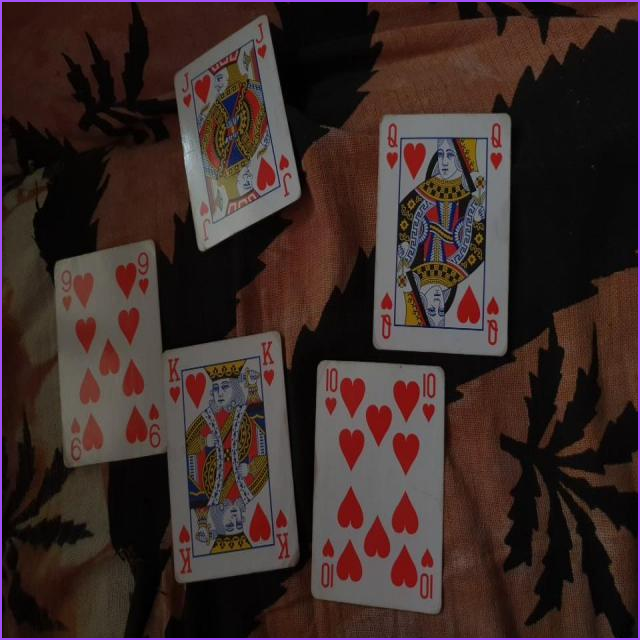
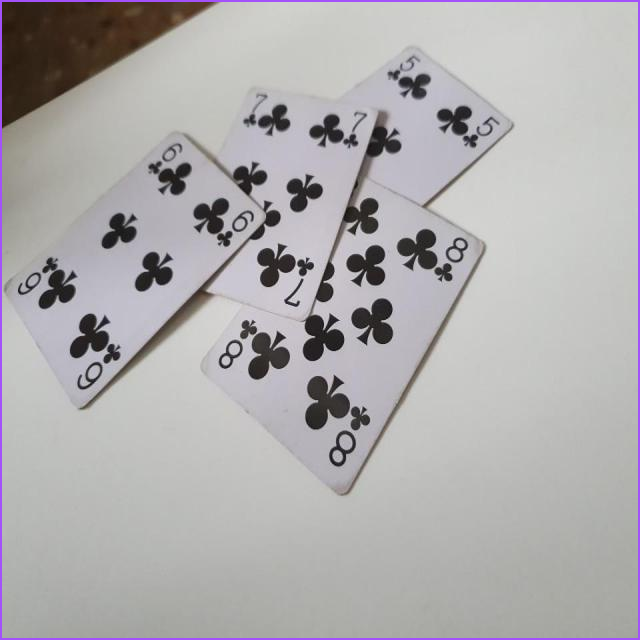
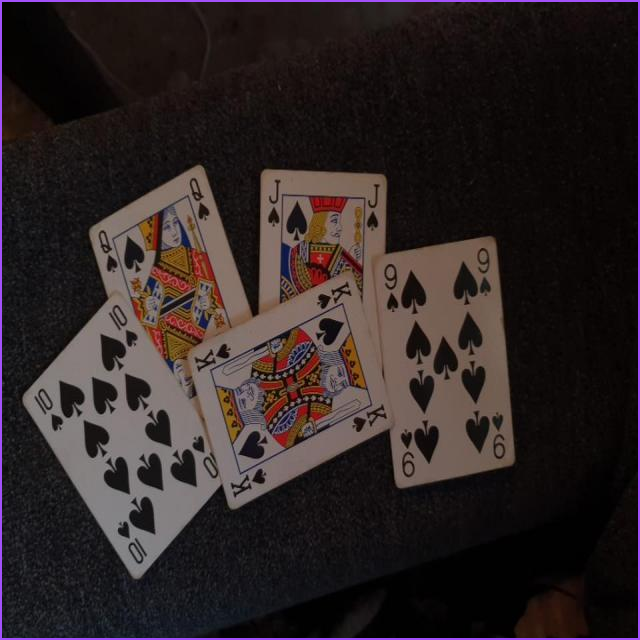
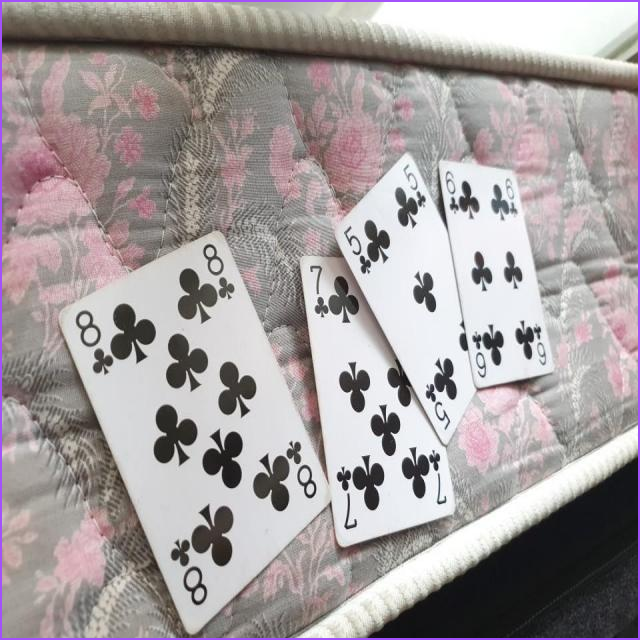

In [18]:
# 지금은 잘못된 정보만 나오게 됨

render_inference_results(peft_model, val_dataset, 4)

## Fine-tune Florence-2 on custom object detection dataset

In [19]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)
            
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

In [20]:
%%time

EPOCHS = 10
LR = 5e-6

if not os.path.exists("./model_checkpoints"):
    train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

CPU times: user 51 µs, sys: 7 µs, total: 58 µs
Wall time: 103 µs


## Load Model

In [21]:
from peft import PeftModel, PeftConfig
from transformers import AutoProcessor

CHECKPOINT = "microsoft/Florence-2-base-ft"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, torch_dtype='auto').eval().to(DEVICE)

peft_model_path = "./model_checkpoints/epoch_10"
peft_model = PeftModel.from_pretrained(base_model, peft_model_path)

processor = AutoProcessor.from_pretrained(peft_model_path, trust_remote_code=True)

## Evalutation

In [22]:
PATTERN = r'([a-zA-Z0-9]+ of [a-zA-Z0-9]+)<loc_\d+>' # ()부분만 캡쳐됨 +는 앞에 있는 문자가 1개 이상 나오는 것을 의미

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data['suffix']
        classes = re.findall(PATTERN, suffix) # 튜플 형태로 반환
        
        class_set.update(classes)
        
    return sorted(class_set)

In [23]:
CLASSES = extract_classes(train_dataset)
print(CLASSES)

['10 of clubs', '10 of diamonds', '10 of hearts', '10 of spades', '2 of clubs', '2 of diamonds', '2 of hearts', '2 of spades', '3 of clubs', '3 of diamonds', '3 of hearts', '3 of spades', '4 of clubs', '4 of diamonds', '4 of hearts', '4 of spades', '5 of clubs', '5 of diamonds', '5 of hearts', '5 of spades', '6 of clubs', '6 of diamonds', '6 of hearts', '6 of spades', '7 of clubs', '7 of diamonds', '7 of hearts', '7 of spades', '8 of clubs', '8 of diamonds', '8 of hearts', '8 of spades', '9 of clubs', '9 of diamonds', '9 of hearts', '9 of spades', 'ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades']


In [31]:
targets = []
predictions = []

for i in tqdm(range(len(val_dataset.dataset))):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE, peft_model.dtype)
    generated_ids = peft_model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    
    prediction = processor.post_process_generation(generated_text, task=prefix, image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    if len(prediction) > 0:
        prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))
    
    target = processor.post_process_generation(suffix, task=prefix, image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])
    
    targets.append(target)
    predictions.append(prediction)

  2%|▏         | 1/44 [00:00<00:22,  1.95it/s]

Detections(xyxy=array([[ 45.12    , 234.56    , 170.56    , 474.56    ],
       [306.88    , 358.08    , 449.59998 , 616.64    ],
       [170.56    ,  10.559999, 305.6     , 257.6     ],
       [369.6     , 109.119995, 514.88    , 362.56    ],
       [160.95999 , 326.08    , 304.32    , 589.12    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


  5%|▍         | 2/44 [00:00<00:16,  2.53it/s]

Detections(xyxy=array([[335.03998,  45.12   , 514.88   , 207.04   ],
       [  0.96   , 129.59999, 267.19998, 410.56   ],
       [200.     ,  87.36   , 379.84   , 323.52   ],
       [198.08   , 173.76   , 486.08   , 497.59998]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


  7%|▋         | 3/44 [00:01<00:16,  2.48it/s]

Detections(xyxy=array([[369.6    , 233.28   , 520.64   , 497.59998],
       [ 19.52   , 287.04   , 223.68   , 586.56   ],
       [255.04   , 166.08   , 392.63998, 378.56   ],
       [ 86.08   , 161.59999, 253.12   , 401.6    ],
       [186.56   , 271.04   , 397.12   , 514.88   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of spades', '10 of spade', 'jack of sp clubs',
       'queen of spoons', 'king of sp hearts'], dtype='<U17')})


  9%|▉         | 4/44 [00:01<00:14,  2.72it/s]

Detections(xyxy=array([[333.75998, 150.08   , 479.03998, 447.03998],
       [438.08   , 157.12   , 556.48   , 390.08   ],
       [298.56   , 255.04   , 458.56   , 550.08   ],
       [ 57.28   , 230.08   , 333.12   , 637.12   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


 11%|█▏        | 5/44 [00:01<00:13,  2.89it/s]

Detections(xyxy=array([[464.31998, 216.64   , 639.68   , 410.56   ],
       [326.08   , 184.64   , 474.56   , 401.6    ],
       [205.12   , 280.63998, 349.12   , 470.08   ],
       [ 13.12   , 246.08   , 217.92   , 474.56   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of hearts', '6 of hearts', '7 of hearts', '8 of hearts'],
      dtype='<U11')})


 14%|█▎        | 6/44 [00:02<00:12,  3.00it/s]

Detections(xyxy=array([[ 97.6     , 433.59998 , 314.56    , 563.51996 ],
       [310.08    , 423.36    , 548.8     , 563.51996 ],
       [ 10.559999, 225.59999 , 276.16    , 427.84    ],
       [292.8     , 173.76    , 627.51996 , 399.03998 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


 16%|█▌        | 7/44 [00:02<00:12,  2.97it/s]

Detections(xyxy=array([[362.56   , 232.64   , 616.64   , 399.03998],
       [326.08   ,  97.6    , 538.56   , 250.56   ],
       [130.23999, 121.92   , 326.08   , 266.56   ],
       [ 13.12   , 271.04   , 279.36   , 532.8    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of spades', '2 of spade', '3 of sp clubs', '4 of spoons'],
      dtype='<U13')})


 18%|█▊        | 8/44 [00:02<00:12,  2.87it/s]

Detections(xyxy=array([[328.63998 , 225.59999 , 536.64    , 522.56    ],
       [275.52    , 147.52    , 438.08    , 435.52    ],
       [131.52    , 126.399994, 301.12    , 390.08    ],
       [159.04    , 326.08    , 321.6     , 563.51996 ],
       [ 40.64    , 182.08    , 218.56    , 461.12    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'jack of diamonds', 'queen of diamonds',
       'king of diamonds', '10 of diamonds'], dtype='<U17')})


 20%|██        | 9/44 [00:03<00:12,  2.88it/s]

Detections(xyxy=array([[184.     ,  22.08   , 326.08   , 170.56   ],
       [184.     , 205.12   , 329.91998, 353.6    ],
       [191.04   , 333.12   , 342.08   , 493.75998],
       [195.51999, 488.63998, 342.08   , 639.68   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['8 of spades', '5 of sp clubs', '7 of spade', '6 of spoons'],
      dtype='<U13')})


 23%|██▎       | 10/44 [00:03<00:11,  2.99it/s]

Detections(xyxy=array([[310.08    , 182.08    , 449.59998 , 433.59998 ],
       [479.03998 , 169.92    , 621.12    , 429.12    ],
       [  8.639999, 201.28    , 169.92    , 479.03998 ],
       [166.08    , 179.51999 , 305.6     , 422.08    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of clubs', '2 of clubs', '3 of clubs', '4 of clubs'],
      dtype='<U12')})


 25%|██▌       | 11/44 [00:03<00:10,  3.05it/s]

Detections(xyxy=array([[102.079994, 122.56    , 241.59999 , 385.6     ],
       [143.04    , 203.84    , 346.56    , 528.32    ],
       [205.12    ,  87.36    , 417.59998 , 362.56    ],
       [225.59999 , 346.56    , 401.6     , 594.88    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


 27%|██▋       | 12/44 [00:04<00:10,  2.93it/s]

Detections(xyxy=array([[320.96    ,  38.079998, 483.52    , 298.56    ],
       [ 88.64    , 303.03998 , 180.8     , 497.59998 ],
       [193.59999 , 369.6     , 301.12    , 593.6     ],
       [338.88    , 369.6     , 472.      , 600.64    ],
       [169.92    ,  75.84    , 296.63998 , 310.08    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'jack of diamonds', 'queen of diamonds',
       'king of diamonds', '10 of diamonds'], dtype='<U17')})


 30%|██▉       | 13/44 [00:04<00:10,  2.93it/s]

Detections(xyxy=array([[254.4     , 307.52    , 470.08    , 595.51996 ],
       [239.04    ,  77.119995, 424.63998 , 273.6     ],
       [344.      , 233.28    , 530.88    , 481.59998 ],
       [186.56    , 230.72    , 410.56    , 418.24    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'loc_234> device', 'queen of diamonds',
       'king of diamonds'], dtype='<U17')})


 32%|███▏      | 14/44 [00:04<00:10,  2.82it/s]

Detections(xyxy=array([[248.64    ,  24.64    , 397.12    , 255.04    ],
       [352.96    , 198.08    , 483.52    , 433.59998 ],
       [269.12    , 255.04    , 429.12    , 528.32    ],
       [129.59999 ,  47.039997, 320.32    , 321.6     ],
       [145.59999 , 311.36    , 349.75998 , 635.2     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of clubs', '10 of clubs', 'jack  of clubs', 'queen of clubs',
       'king of clubs'], dtype='<U14')})


 34%|███▍      | 15/44 [00:05<00:09,  2.94it/s]

Detections(xyxy=array([[317.12   , 161.59999, 465.59998, 429.12   ],
       [ 24.64   , 173.76   , 179.51999, 458.56   ],
       [479.03998, 166.08   , 616.64   , 431.03998],
       [173.12   , 162.87999, 317.75998, 429.12   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of clubs', '2 of clubs', '3 of clubs', '4 of clubs'],
      dtype='<U12')})


 36%|███▋      | 16/44 [00:05<00:09,  3.01it/s]

Detections(xyxy=array([[136.64   , 287.04   , 337.6    , 493.75998],
       [238.4    ,  70.08   , 379.84   , 317.12   ],
       [278.08   , 161.59999, 472.63998, 447.03998],
       [160.95999, 122.56   , 271.04   , 312.63998]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of diamonds', '6 of diamonds', '7 of diamonds', '8 of diamonds'],
      dtype='<U13')})


 39%|███▊      | 17/44 [00:05<00:08,  3.08it/s]

Detections(xyxy=array([[296.      ,  58.559998, 479.03998 , 403.52    ],
       [456.      ,  65.6     , 639.68    , 355.52    ],
       [250.56    , 195.51999 , 394.56    , 470.08    ],
       [  0.96    , 166.08    , 252.48    , 497.59998 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


 41%|████      | 18/44 [00:06<00:08,  2.94it/s]

Detections(xyxy=array([[ 90.56    ,  34.88    , 264.63998 , 273.6     ],
       [129.59999 , 390.08    , 328.63998 , 639.68    ],
       [275.52    ,  38.079998, 486.08    , 283.84    ],
       [301.12    , 326.08    , 548.8     , 616.64    ],
       [ 72.64    , 214.08    , 271.04    , 474.56    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


 43%|████▎     | 19/44 [00:06<00:08,  3.03it/s]

Detections(xyxy=array([[493.12   , 178.87999, 614.07996, 408.63998],
       [  5.44   , 179.51999, 189.12   , 456.     ],
       [323.52   , 150.08   , 461.75998, 394.56   ],
       [169.92   , 176.31999, 317.12   , 424.63998]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


 45%|████▌     | 20/44 [00:06<00:07,  3.08it/s]

Detections(xyxy=array([[248.64    ,  61.12    , 397.12    , 291.52    ],
       [ 79.04    , 142.4     , 317.12    , 447.03998 ],
       [126.399994, 343.36    , 403.52    , 618.56    ],
       [304.96    , 171.2     , 511.03998 , 451.52    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of clubs', '6 of clubs', '7 of clubs', '8 of clubs'],
      dtype='<U10')})


 48%|████▊     | 21/44 [00:07<00:08,  2.71it/s]

Detections(xyxy=array([[233.28    , 342.08    , 326.08    , 550.08    ],
       [328.63998 , 109.119995, 502.08    , 346.56    ],
       [328.63998 , 326.08    , 449.59998 , 609.6     ],
       [233.28    , 173.12    , 353.6     , 342.08    ],
       [134.08    , 417.59998 , 189.12    , 522.56    ],
       [129.59999 , 276.8     , 186.56    , 381.12    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of spades', '2 of spade', '3 of sp clubs', '4 of spoons',
       '5 of springs', '7 of sp forks'], dtype='<U13')})


 50%|█████     | 22/44 [00:07<00:08,  2.70it/s]

Detections(xyxy=array([[399.03998, 233.28   , 616.64   , 538.56   ],
       [129.59999,  83.52   , 303.03998, 335.03998],
       [230.08   , 280.63998, 440.63998, 607.04   ],
       [ 73.92   , 314.56   , 267.19998, 639.68   ],
       [275.52   ,  45.12   , 454.08   , 283.84   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


 52%|█████▏    | 23/44 [00:08<00:07,  2.69it/s]

Detections(xyxy=array([[211.51999  ,   1.5999999, 371.52     , 278.08     ],
       [323.52     , 176.31999  , 561.6      , 511.03998  ],
       [222.4      , 303.03998  , 404.8      , 595.51996  ],
       [138.56     , 147.52     , 255.04     , 401.6      ],
       [153.28     , 385.6      , 288.32     , 639.68     ]],
      dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'jack of diamonds', 'queen of diamonds',
       'king of diamonds', '10 of diamonds'], dtype='<U17')})


 55%|█████▍    | 24/44 [00:08<00:07,  2.83it/s]

Detections(xyxy=array([[121.92   , 305.6    , 335.03998, 522.56   ],
       [230.08   ,  72.64   , 378.56   , 333.12   ],
       [272.96   , 166.08   , 479.03998, 470.72   ],
       [145.59999, 129.59999, 267.19998, 328.63998]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of diamonds', '6 of diamonds', '7 of diamonds', '8 of diamonds'],
      dtype='<U13')})


 57%|█████▋    | 25/44 [00:08<00:06,  2.95it/s]

Detections(xyxy=array([[ 40.64   , 129.59999, 223.68   , 397.12   ],
       [184.     , 189.12   , 346.56   , 445.75998],
       [303.03998, 243.51999, 459.84   , 497.59998],
       [431.03998, 290.88   , 585.27997, 553.27997]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of diamonds', '6 of diamonds', '7 of diamonds', '8 of diamonds'],
      dtype='<U13')})


 59%|█████▉    | 26/44 [00:09<00:06,  2.86it/s]

Detections(xyxy=array([[184.      , 266.56    , 378.56    , 616.64    ],
       [362.56    , 312.63998 , 569.27997 , 593.6     ],
       [242.23999 ,  87.36    , 401.6     , 273.6     ],
       [399.03998 , 129.59999 , 534.08    , 326.08    ],
       [ 65.6     ,  46.399998, 241.59999 , 273.6     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


 61%|██████▏   | 27/44 [00:09<00:05,  2.96it/s]

Detections(xyxy=array([[454.08    , 136.64    , 568.64    , 410.56    ],
       [  8.639999, 136.64    , 335.03998 , 486.08    ],
       [344.63998 , 271.04    , 465.59998 , 553.27997 ],
       [253.76    , 127.04    , 413.75998 , 466.87997 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of hearts', '6 of hearts', '7 of hearts', '8 of hearts'],
      dtype='<U11')})


 64%|██████▎   | 28/44 [00:09<00:05,  3.04it/s]

Detections(xyxy=array([[178.87999 , 403.52    , 362.56    , 639.68    ],
       [ 52.8     , 246.08    , 285.75998 , 518.72    ],
       [337.6     , 307.52    , 469.44    , 525.12    ],
       [275.52    ,  93.119995, 422.08    , 317.12    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of diamonds', '2 of diamonds', '3 of diamonds',
       '4 of diamonds'], dtype='<U15')})


 66%|██████▌   | 29/44 [00:10<00:05,  2.90it/s]

Detections(xyxy=array([[102.079994,  93.119995, 247.36    , 241.59999 ],
       [250.56    , 100.799995, 386.88    , 250.56    ],
       [374.08    ,  93.119995, 536.64    , 241.59999 ],
       [147.52    , 257.6     , 344.      , 518.72    ],
       [328.      , 247.36    , 546.24    , 502.08    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of clubs', '10 of clubs', 'jack  of clubs', 'queen of clubs',
       'king of clubs'], dtype='<U14')})


 68%|██████▊   | 30/44 [00:10<00:04,  3.00it/s]

Detections(xyxy=array([[205.12    ,  19.52    , 346.56    , 217.28    ],
       [126.399994, 243.51999 , 298.56    , 474.56    ],
       [303.03998 , 154.56    , 433.59998 , 358.08    ],
       [225.59999 , 346.56    , 401.6     , 598.08    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of diamonds', '2 of diamonds', '3 of diamonds',
       '4 of diamonds'], dtype='<U15')})


 70%|███████   | 31/44 [00:10<00:04,  2.98it/s]

Detections(xyxy=array([[337.6     , 266.56    , 561.6     , 532.8     ],
       [ 83.52    , 102.079994, 281.91998 , 410.56    ],
       [266.56    ,  56.64    , 424.      , 337.6     ],
       [152.64    , 326.08    , 390.08    , 609.6     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of spades', '2 of sp clubs', '3 of spoons', '4 of spade'],
      dtype='<U13')})


 73%|███████▎  | 32/44 [00:11<00:04,  2.88it/s]

Detections(xyxy=array([[100.799995, 120.64    , 202.56    , 346.56    ],
       [335.03998 ,  13.12    , 489.91998 , 310.08    ],
       [138.56    , 344.63998 , 259.52    , 607.04    ],
       [266.56    , 328.63998 , 410.56    , 630.72    ],
       [211.51999 ,  71.36    , 326.08    , 328.63998 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'jack of diamonds', 'queen of diamonds',
       'king of diamonds', '10 of diamonds'], dtype='<U17')})


 75%|███████▌  | 33/44 [00:11<00:03,  2.98it/s]

Detections(xyxy=array([[473.28   , 136.64   , 632.64   , 394.56   ],
       [  0.96   , 257.6    , 159.68   , 532.8    ],
       [178.87999, 192.31999, 329.91998, 449.59998],
       [307.52   , 152.64   , 470.72   , 401.6    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of hearts', '2 of hearts', '3 of hearts', '4 of hearts'],
      dtype='<U13')})


 77%|███████▋  | 34/44 [00:11<00:03,  2.88it/s]

Detections(xyxy=array([[  0.96   , 250.56   , 170.56   , 497.59998],
       [134.08   , 246.08   , 297.28   , 486.08   ],
       [298.56   , 230.08   , 447.03998, 479.03998],
       [441.28   , 246.08   , 627.51996, 511.03998],
       [214.08   , 493.75998, 342.08   , 639.68   ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


 80%|███████▉  | 35/44 [00:12<00:03,  2.72it/s]

Detections(xyxy=array([[310.08    , 346.56    , 486.08    , 486.08    ],
       [344.63998 ,  45.12    , 561.6     , 312.63998 ],
       [237.12    , 449.59998 , 394.56    , 563.51996 ],
       [ 82.24    , 287.04    , 288.32    , 454.08    ],
       [254.4     , 118.079994, 443.19998 , 358.08    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of spades', '10 of spade', 'jack of sp clubs',
       'queen of spoons', 'king of sp hearts'], dtype='<U17')})


 82%|████████▏ | 36/44 [00:12<00:03,  2.63it/s]

Detections(xyxy=array([[184.      ,  79.04    , 335.03998 , 273.6     ],
       [317.12    ,  79.04    , 502.08    , 241.59999 ],
       [287.04    , 205.12    , 488.63998 , 447.03998 ],
       [454.08    , 183.36    , 627.51996 , 408.63998 ],
       [ 10.559999, 234.56    , 258.88    , 538.56    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of spades', '10 of spade', 'jack of sp clubs',
       'queen of spoons', 'king of sp hearts'], dtype='<U17')})


 84%|████████▍ | 37/44 [00:12<00:02,  2.63it/s]

Detections(xyxy=array([[ 72.64    , 303.03998 , 280.63998 , 616.64    ],
       [365.75998 , 303.03998 , 474.56    , 532.8     ],
       [138.56    ,  34.88    , 335.03998 , 303.03998 ],
       [360.63998 , 109.119995, 467.52    , 319.03998 ],
       [254.4     , 337.6     , 403.52    , 612.16    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


 86%|████████▋ | 38/44 [00:13<00:02,  2.65it/s]

Detections(xyxy=array([[232.64    ,  31.039999, 369.6     , 193.59999 ],
       [153.28    , 351.03998 , 349.75998 , 627.51996 ],
       [292.8     , 292.16    , 447.03998 , 525.12    ],
       [365.75998 , 184.64    , 488.63998 , 369.6     ],
       [129.59999 , 109.119995, 299.84    , 328.63998 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'jack of diamonds', 'queen of diamonds',
       'king of diamonds', '10 of diamonds'], dtype='<U17')})


 89%|████████▊ | 39/44 [00:13<00:01,  2.73it/s]

Detections(xyxy=array([[ 83.52   , 178.87999, 278.08   , 342.08   ],
       [342.72   , 152.64   , 550.08   , 335.03998],
       [273.6    , 353.6    , 493.75998, 547.51996],
       [ 45.76   , 337.6    , 262.08   , 511.03998]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['ace of spades', '4 of sp clubs', '3 of spoons', '2 of sp forks'],
      dtype='<U13')})


 91%|█████████ | 40/44 [00:14<00:01,  2.71it/s]

Detections(xyxy=array([[194.87999 , 202.56    , 362.56    , 514.24    ],
       [233.92    ,  30.4     , 461.75998 , 241.59999 ],
       [383.03998 , 148.8     , 566.72    , 447.03998 ],
       [ 42.559998, 214.08    , 230.08    , 532.8     ],
       [307.52    , 221.12    , 454.08    , 514.88    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of hearts', '10 of hearts', 'jack of hearts', 'queen of hearts',
       'king of hearts'], dtype='<U15')})


 93%|█████████▎| 41/44 [00:14<00:01,  2.61it/s]

Detections(xyxy=array([[317.12    , 280.63998 , 520.64    , 502.08    ],
       [205.12    ,  79.04    , 424.63998 , 303.03998 ],
       [310.08    , 449.59998 , 493.75998 , 616.64    ],
       [116.799995, 390.08    , 314.56    , 598.08    ],
       [178.87999 , 239.04    , 379.84    , 401.6     ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of spades', '10 of sp clubs', 'jack of spade',
       'queen of spoons', 'king of sp hearts'], dtype='<U17')})


 95%|█████████▌| 42/44 [00:14<00:00,  2.78it/s]

Detections(xyxy=array([[ 31.039999, 136.64    , 179.51999 , 378.56    ],
       [133.44    , 161.59999 , 294.08    , 429.12    ],
       [238.4     , 198.08    , 433.59998 , 506.56    ],
       [376.63998 , 250.56    , 616.64    , 626.24    ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['5 of hearts', '6 of hearts', '7 of hearts', '8 of hearts'],
      dtype='<U11')})


 98%|█████████▊| 43/44 [00:15<00:00,  2.74it/s]

Detections(xyxy=array([[ 77.119995, 344.63998 , 289.6     , 577.6     ],
       [266.56    ,  87.36    , 399.03998 , 291.52    ],
       [287.04    , 294.08    , 486.08    , 550.08    ],
       [129.59999 , 127.04    , 269.12    , 353.6     ],
       [399.03998 ,  90.56    , 563.51996 , 319.03998 ]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of diamonds', 'jack of diamonds', 'queen of diamonds',
       'king of diamonds', '10 of diamonds'], dtype='<U17')})


100%|██████████| 44/44 [00:15<00:00,  2.83it/s]

Detections(xyxy=array([[ 86.08   , 374.08   , 353.6    , 639.68   ],
       [296.     , 121.92   , 474.56   , 289.6    ],
       [145.59999, 198.08   , 342.08   , 442.56   ],
       [207.04   ,  61.12   , 383.03998, 217.92   ],
       [337.6    , 193.59999, 601.92   , 440.63998]], dtype=float32), mask=None, confidence=None, class_id=None, tracker_id=None, data={'class_name': array(['9 of clubs', '10 of clubs', 'jack  of clubs', 'queen of clubs',
       'king of clubs'], dtype='<U14')})


In [32]:
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.73
map50: 0.78
map75: 0.78


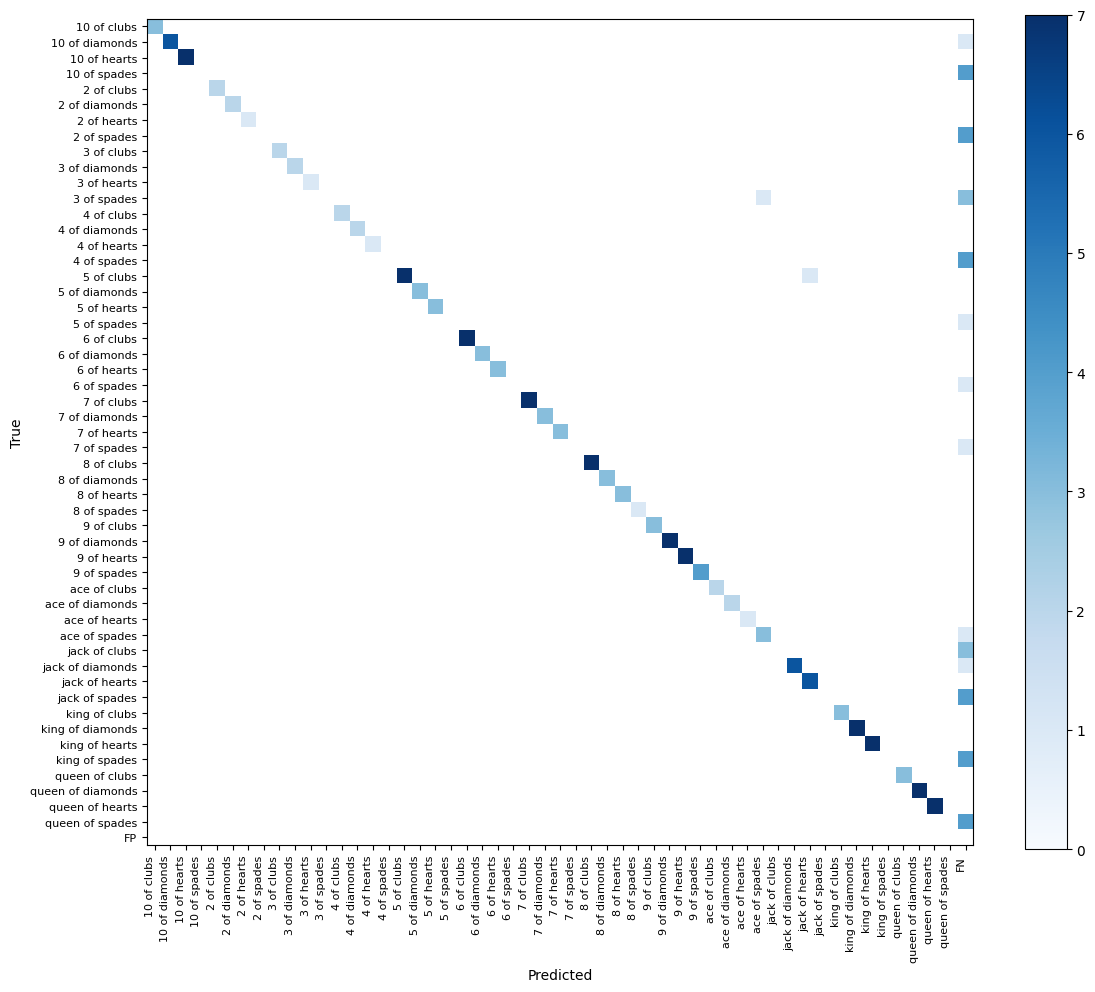

In [33]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [34]:
peft_model.save_pretrained("./model_checkpoints/florence2-lora")
processor.save_pretrained("./model_checkpoints/florence2-lora/")

Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.


['./model_checkpoints/florence2-lora/processor_config.json']

## Upload to Roboflow Project

In [41]:
from dotenv import load_dotenv
load_dotenv()

print(os.getenv("ROBOFLOW_API_KEY"))
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
workspace = rf.workspace("hsit-ntlib")

# https://docs.roboflow.com/api-reference/images/upload-dataset

workspace.upload_dataset(
    "./poker-cards-4/", # This is your dataset path
    "florence2-poker-card", # This will either create or get a dataset with the given ID
    num_workers=10,
    project_license="MIT",
    project_type="object-detection",
    batch_name=None,
    num_retries=0
)

2pKBv3TsNPQAmJm6AMzm
loading Roboflow workspace...


100%|██████████| 899/899 [00:00<00:00, 9188.40it/s]

loading Roboflow project...


Uploading to existing project hsit-ntlib/florence2-poker-card
[UPLOADED] ./poker-cards-4/test/IMG_20220316_140255_jpg.rf.0d10768652a0f20bea317e96632d3448.jpg (L3hGUhJ0IXblbuQfXJ5c) [1.6s] / annotations = OK [0.8s]
[UPLOADED] ./poker-cards-4/test/IMG_20220316_134701_jpg.rf.27aa29de9d6012ae05c64b156f7c07b8.jpg (5Id7tCXGXf0qaDPG7i5Z) [1.8s] / annotations = OK [0.7s]
[UPLOADED] ./poker-cards-4/test/IMG_20220316_141442_jpg.rf.41913768e5d56c57566ee3b45391470d.jpg (4aZhYAiw2LnAtn5xCQY5) [1.9s] / annotations = OK [0.8s]
[UPLOADED] ./poker-cards-4/test/IMG_20220316_135012_jpg.rf.ee7179374d33235528db011cb5418226.jpg (FI16nzDSejqD0lnuFGdO) [2.1s] / annotations = OK [0.7s]
[UPLOADED] ./poker-cards-4/test/IMG_20220316_135021_jpg.rf.d038afdef1a927103dae268ff392888f.jpg (1rIEWP2VtIl4RKzX0LCR) [2.0s] / annotations = OK [0.9s]
[UPLOADED] ./poker-cards-4/test/IMG_20220316_141917_jpg.rf.b3075e4161fe5fa2285d75bb2da3bc7a.jpg (UKLw3fHKbjYoRduJ1lls) [2.3s] / annotations = OK [0.8s]
[UPLOADED] ./poker-cards-4

TypeError: upload() missing 1 required positional argument: 'image_path'

In [42]:
project.version(1).deploy(model_type="florence-2-base", model_path="./model_checkpoints/florence2-lora")

Model files found in ./model_checkpoints/florence2-lora: ['processor_config.json', 'added_tokens.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json', 'merges.txt', 'processing_florence2.py', 'roboflow_deploy.tar', 'README.md', 'adapter_model.safetensors', 'special_tokens_map.json', 'preprocessor_config.json', 'adapter_config.json']
Found .safetensors file in model path. Deploying PyTorch florence-2-base model.
Zipping files for deploy: ['processor_config.json', 'added_tokens.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json', 'merges.txt', 'processing_florence2.py', 'roboflow_deploy.tar', 'README.md', 'adapter_model.safetensors', 'special_tokens_map.json', 'preprocessor_config.json', 'adapter_config.json']
Uploading to Roboflow... May take several minutes.
View the status of your deployment at: https://app.roboflow.com/hsit-ntlib/florence2-poker-card/1
Share your model with the world at: https://universe.roboflow.com/hsit-ntlib/florence2-poker-card/model/1


In [40]:
project.generate_version(settings={})

RuntimeError: augmentation and preprocessing keys are required to generate. If none are desired specify empty dict associated with that key.